In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt

df=pd.read_csv('Weather Data.csv', index_col='Date/Time' ,parse_dates=['Date/Time'])

df=df.dropna()
df.head()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
Date/Time,,,,,,,
2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [2]:
print('Shape of data',df.shape)

Shape of data (8784, 7)


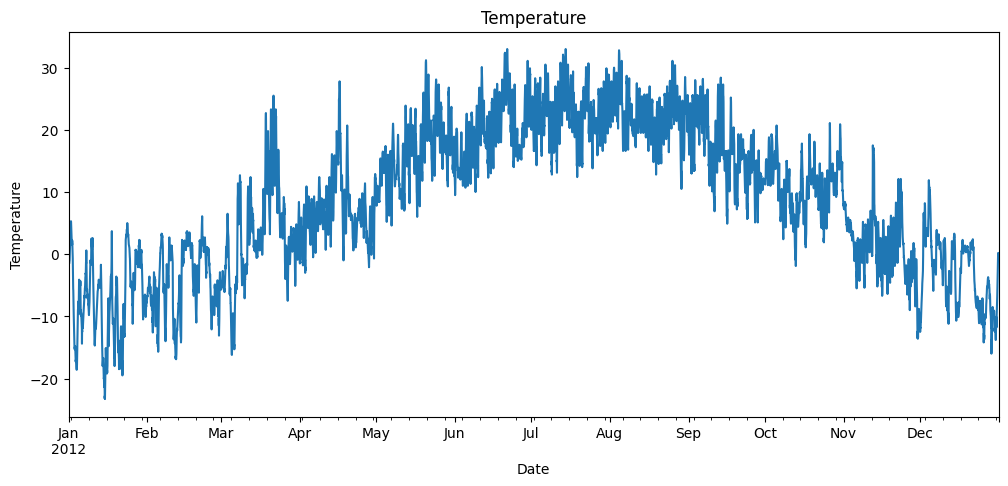

In [3]:
df['Temp_C'].plot(figsize=(12, 5))
plt.title('Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [4]:
# Preprocess the data
data = df['Temp_C'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [5]:
sequence_length = 30  # how many previous time steps are considered when predicting the temperature at the current time step.

Creates sequences of 30 days as input features and the temperature of the next day as the target value.

In [6]:
# Prepare data for training
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length, 0])
    y.append(data_scaled[i+sequence_length, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  #(number of samples, sequence length=30, number of features=1)
X.shape

(8754, 30, 1)

In [7]:
# Split the dataset into training and testing sets
split = int(0.8 * len(data_scaled))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(X.shape[1], 1), activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1361 (5.32 KB)
Trainable params: 1361 (5.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7027, 30, 1)
X_test shape: (1727, 30, 1)
y_train shape: (7027,)
y_test shape: (1727,)


In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=26, validation_split=0.1, verbose=1)

# Make predictions
test_predictions_scaled = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions_scaled).flatten()

Epoch 1/50

244/244 [==============================] - 5s 8ms/step - loss: 0.0338 - val_loss: 6.6155e-04
Epoch 2/50
244/244 [==============================] - 2s 6ms/step - loss: 6.6768e-04 - val_loss: 5.8143e-04
Epoch 3/50
244/244 [==============================] - 2s 7ms/step - loss: 5.6791e-04 - val_loss: 5.0014e-04
Epoch 4/50
244/244 [==============================] - 2s 7ms/step - loss: 4.8255e-04 - val_loss: 4.5957e-04
Epoch 5/50
244/244 [==============================] - 2s 7ms/step - loss: 3.9256e-04 - val_loss: 3.5523e-04
Epoch 6/50
244/244 [==============================] - 2s 7ms/step - loss: 3.6530e-04 - val_loss: 4.5658e-04
Epoch 7/50
244/244 [==============================] - 2s 7ms/step - loss: 3.5723e-04 - val_loss: 2.9679e-04
Epoch 8/50
244/244 [==============================] - 2s 7ms/step - loss: 3.3817e-04 - val_loss: 2.9194e-04
Epoch 9/50
244/244 [==============================] - 2s 8ms/step - loss: 3.3449e-04 - val_loss: 2.7449e-04
Epoch 10/50
244/244 [==========

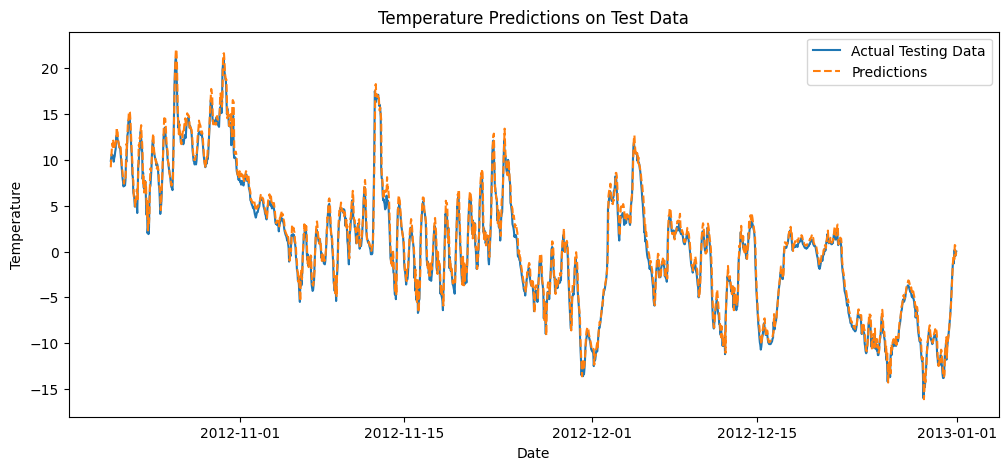

In [11]:
# Plotting predictions vs. actual
plt.figure(figsize=(12, 5))
plt.plot(df.index[split+sequence_length:], df['Temp_C'][split+sequence_length:], label='Actual Testing Data')
plt.plot(df.index[split+sequence_length:], test_predictions, label='Predictions', linestyle='dashed')
plt.title('Temperature Predictions on Test Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [12]:
# Calculating RMSE for test predictions
from sklearn.metrics import mean_squared_error
from math import sqrt

test_actual_temps = df['Temp_C'][split + sequence_length:].values
test_mse = mean_squared_error(test_actual_temps, test_predictions)
test_rmse = sqrt(test_mse)

print(f"Root Mean Squared Error (RMSE) on Test Data: {test_rmse}")


Root Mean Squared Error (RMSE) on Test Data: 0.9095583887408591


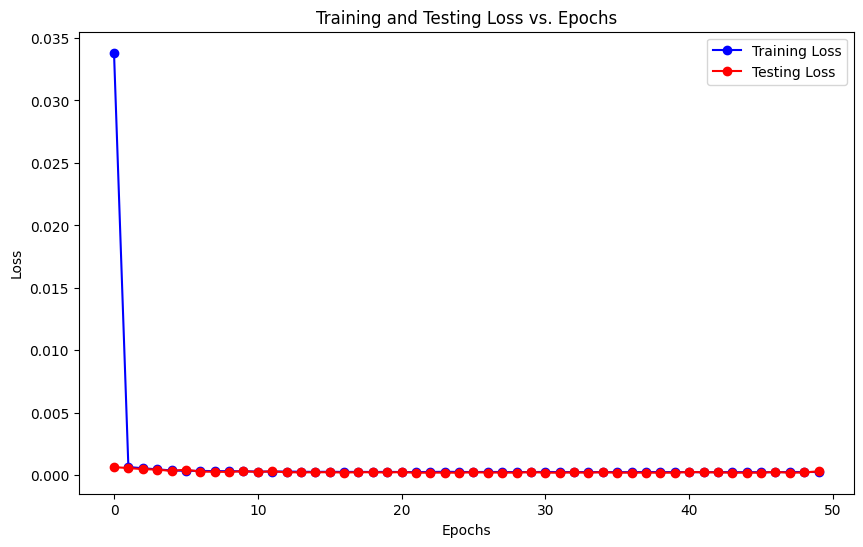

In [13]:
# Plotting Training and Testing Loss vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Testing Loss')
plt.title('Training and Testing Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
